# Train a neural network to predict MHC ligands
The notebook consists of the following sections:

0. Module imports, define functions, set constants
1. Load Data
2. Build Model
3. Select Hyper-paramerters
4. Compile Model
5. Train Model
6. Evaluation

## Exercise

The exercise is to create from scratch a Feed-Forward Neural Network (FFNN) by coding its forward and backward loop. Then, optimize the model given in this notebook by selecting hyper-parameters that improve performance. First run the notebook as is and take notes of the performance (AUC). Then start a manual hyper-parameter search by following the instructions below. If your first run results in poor fitting (the model doesn't learn anything during training) do not dispair! Hopefully you will see a rapid improvement when you start testing other hyper-parameters.


### Number of hidden units
Try increasing the number of model parameters (weights), eg. 16, 32, or 64.

### Parameter initialization
Parameter initialization can be extremely important.
[initializers](http://pytorch.org/docs/master/nn.html#torch-nn-init) and the most often used initializers are listed below. Have a look at how they're implemented.
1. Kaming He
2. Uniform or Normal with small scale (0.1 - 0.01)

Bias is nearly always initialized to zero

### Nonlinearity
Non-linearity is what makes neural networks universal predictors. Not everything in our universe is related by linearity and therefore we must implement non-linear activations to cope with that. [The most commonly used nonliearities](http://pytorch.org/docs/master/nn.html#non-linear-activations) are listed below. 
1. ReLU
2. Sigmoid squash the output [0, 1], and are used if your output is binary (not used in the hidden layers)
3. Tanh is similar to sigmoid, but squashes in [-1, 1]. It is rarely used any more.
5. Softmax normalizes the the output to 1, and is used as output if you have a classification problem

Change the current function to another. To do so, you must modify the forward()-method in the SimpleFFNN()-class. 

### Mix of peptide lengths
Now you have hopefully found an architecture that yields a pretty good performance. But of course it is not that simple... One of the issues that occur when working with real data is that ligands can have lengths of 8, 10, or 11 amino acids. In order to accomodate different lengths you need to pad your sequences, so they still fit into the expected tensor. This, however, may mess with the weights of the anchor positions.

Try and include 8-9-10-11mers and take a look at how it affects performance by having a look at the A0301 allele data.


#### Performance evaluation
Run the notebook and take a look at how the model performs on data partitioned by peptide length. 

1. What happens to the performance evaluated on 8-10-11mers (excluding 9mers) compared to performance evaluated only on peptides of length 9?

Can you explain why we would prefer a good performance on 8-9-10-11mers over a higher performance on only 9mers?

# Utility functions

In [1]:
import numpy as np
import pandas as pd
import math
import pickle
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, matthews_corrcoef

C:\Users\hostp\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Utility functions you will re-use
# Data-related utility functions
def load_blosum(filename):
    """
    Read in BLOSUM values into matrix.
    """
    aa = ['A', 'R', 'N' ,'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V', 'X']
    df = pd.read_csv(filename, sep='\s+', comment='#', index_col=0)
    return df.loc[aa, aa]

def load_peptide_target(filename):
    """
    Read amino acid sequence of peptides and
    corresponding log transformed IC50 binding values from text file.
    """
    df = pd.read_csv(filename, sep='\s+', usecols=[0,1], names=['peptide','target'])
    return df.sort_values(by='target', ascending=False).reset_index(drop=True)

def encode_peptides(X_in, blosum_file, max_pep_len=9):
    """
    Encode AA seq of peptides using BLOSUM50.
    Returns a tensor of encoded peptides of shape (1, max_pep_len, n_features) for a single batch
    """
    blosum = load_blosum(blosum_file)
    
    batch_size = len(X_in)
    n_features = len(blosum)
    
    X_out = np.zeros((batch_size, max_pep_len, n_features), dtype=np.int8)
    
    for peptide_index, row in X_in.iterrows():
        for aa_index in range(len(row.peptide)):
            X_out[peptide_index, aa_index] = blosum[ row.peptide[aa_index] ].values
            
    return X_out, np.expand_dims(X_in.target.values,1)


In [3]:
# Misc. functions
def invoke(early_stopping, loss, model, implement=False):
    if implement == False:
        return False
    else:
        early_stopping(loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            return True
        
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def plot_losses(train_losses, valid_losses, n_epochs):
    # Plotting the losses 
    fig,ax = plt.subplots(1,1, figsize=(9,5))
    ax.plot(range(n_epochs), train_losses, label='Train loss', c='b')
    ax.plot(range(n_epochs), valid_losses, label='Valid loss', c='m')
    ax.legend()
    fig.show()

In [4]:
# Weights initialization function.
# xavier initialization is technically more stable and preferred 
# (See slides)
def xavier_initialization_normal(input_dim, output_dim):
    #in_dim, out_dim = shape
    shape = (input_dim, output_dim)
    stddev = np.sqrt(2 / (input_dim + output_dim))
    return np.random.normal(0, stddev, size=shape) * 0.1

def random_initialization_normal(input_dim, output_dim):
    return np.random.randn(input_dim, output_dim) * 0.1

In [5]:
def train_network(net, x_train, y_train, learning_rate):
    """
    Trains the network for a single epoch, running the forward and backward pass, and compute and return the loss.
    """
    # Forward pass
    z1, a1, z2, a2,  = net.forward(x_train)
    # backward pass
    backward(net, x_train, y_train, z1, a1, z2, a2, learning_rate)
    loss = np.mean((a2 - y_train) ** 2)
    return loss
        
def eval_network(net, x_valid, y_valid):
    """
    Evaluates the network ; Note that we do not update weights (no backward pass)
    """
    z1, a1, z2, a2 = net.forward(x_valid)
    loss = np.mean((a2-y_valid)**2)
    return loss

In [6]:
# Model saving and loading functions

def save_ffnn_model(filepath, model):
    if not filepath.endswith('.pkl'):
        filepath = filepath+'.pkl'
    with open(filepath, 'wb') as f:
        dict_to_save = {'input_size': model.W1.shape[0], 'hidden_size':model.W1.shape[1], 'output_size':model.W2.shape[1],
                        'W1': model.W1, 'b1':model.b1, 'W2':model.W2, 'b2':model.b2}
        pickle.dump(dict_to_save, f)
        print(f'Saved FFNN model at {filepath}')


def load_ffnn_model(filepath, model=None):

    with open(filepath, 'rb') as f:
        loaded_dict = pickle.load(f)
    if model is None:
            model = SimpleFFNN(loaded_dict['input_size'], loaded_dict['hidden_size'], loaded_dict['output_size'])
    assert (model.W1.shape[0]==loaded_dict['input_size'] and model.W1.shape[1]==loaded_dict['hidden_size'] and model.W2.shape[1]==loaded_dict['output_size']), \
        f"Model and loaded weights size mismatch!. Provided model has weight of dimensions {model.W1.shape, model.W2.shape} ; Loaded weights have shape {loaded_dict['W1'].shape, loaded_dict['W2'].shape}"

    model.W1 = loaded_dict['W1']
    model.b1 = loaded_dict['b1']
    model.W2 = loaded_dict['W2']
    model.b2 = loaded_dict['b2']
    print(f"Model loaded successfully from {filepath}\nwith weights [ W1, W2 ] dimensions : {model.W1.shape, model.W2.shape}")
    return model

# Data loading and encoding

In [7]:
# Replace your data paths with the actual paths and desired alleles
ALLELE = 'A0301' #A0201' #'A0301'
DATAPATH = '../../data/NNDeep/'
blosum_file = f'{DATAPATH}/BLOSUM50'
train_data = f'{DATAPATH}/{ALLELE}/train_BA'
valid_data = f'{DATAPATH}/{ALLELE}/valid_BA'
test_data = f'{DATAPATH}/{ALLELE}/test_BA'

# Loading the peptides.
train_raw = load_peptide_target(train_data)
valid_raw = load_peptide_target(valid_data)
test_raw = load_peptide_target(test_data)
# 
print('Preview of the dataframe ; Peptides have to be *encoded* to BLOSUM matrices')
#display(train_raw.head())

print('N_datapoints:')
print('Train data:\t', train_raw.shape[0])
print('Valid data:\t', valid_raw.shape[0])
print('Test data:\t', test_raw.shape[0])

print('Maximum peptide length of each data set:')
print('Train:\t',  train_raw['peptide'].apply(len).max())
print('Valid:\t', valid_raw['peptide'].apply(len).max())
print('Test:\t', test_raw['peptide'].apply(len).max())

Preview of the dataframe ; Peptides have to be *encoded* to BLOSUM matrices
N_datapoints:
Train data:	 3951
Valid data:	 1329
Test data:	 1321
Maximum peptide length of each data set:
Train:	 11
Valid:	 11
Test:	 11


In [8]:
train_raw['len']=train_raw['peptide'].apply(len)
print('Peptide length counts in the train data')
display(train_raw.groupby('len').agg(count=('peptide','count')))

Peptide length counts in the train data


,count
len,
8,33
9,2978
10,895
11,45


Peptide encoding : 

We need to ensure that every peptide shorter than the maximum length `max_len_pep` are *padded* to that length when building the matrices, in order for the dimensions to fit. For example, if our `max_pep_len` is 11, then every peptide of length shorter than 11 must be padded to 11. 

For example, for a peptide "GILGFVFTL", of size 9, and a `max_pep_len` of 11, this effectively means that the peptide is first padded to 11 : "GILGFVFTLXX", where "x" means a pad, and then converted to a matrix.



In [9]:
max_pep_len = train_raw.peptide.apply(len).max()
x_train_, y_train_ = encode_peptides(train_raw, blosum_file, max_pep_len)
x_valid_, y_valid_ = encode_peptides(valid_raw, blosum_file, max_pep_len)
x_test_, y_test_ = encode_peptides(test_raw, blosum_file, max_pep_len)
# We now have matrices of shape (N_datapoints, max_pep_len, n_features)
print(x_train_.shape)

(3951, 11, 21)


# Model creation and training

## Model definition

Now it's your turn. We are using a class structure, where a class contains `methods` needed for the forward pass (that just means functions that belong to a class) and you will code the derivatives and backpropagation separately.

For the forward pass, you will need to define the shape of your weight and bias matrices, as well as the actual `forward` pass in terms of matrix multiplications. Additionally, as we are using neural networks, you will also need to code the activation functions (ReLU and Sigmoid).

In [10]:
xavier_initialization_normal??

In [11]:
class SimpleFFNN:
    def __init__(self, input_size, hidden_size, output_size, initialization_function=xavier_initialization_normal):
        # Initialize weights and biases with small random values
        # initialization_function(input_dim, output_dim) -> np.array of shape (input_dim, output_dim)
        #self.W1 = initialization_function(XX, XX)
        #self.b1 = np.zeros(XX)
        #self.W2 = initialization_function(XX, XX)
        #self.b2 = np.zeros(XX)
        self.W1 = initialization_function(input_size, hidden_size)
        self.b1 = np.zeros(hidden_size)
        self.W2 = initialization_function(hidden_size, output_size)
        self.b2 = np.zeros(output_size)
        print(self.W1.shape, self.b1.shape, self.W2.shape, self.b2.shape)
        
    def relu(self, x):
        #return XX
        return np.maximum(0, x)

    def sigmoid(self, x): 
        """
        The normal version of sigmoid 1 / (1 + np.exp(-x)) is NOT numerically stable
        Here we split the case into two for positive and negative inputs
        because np.exp(-x) for something negative will quickly overflow if x is a large negative number
        """
        # This is equivalent to : 
        # if x>=0, then compute (1/(1+np.exp(-x)))
        # if x<0: compute (np.exp(x)/(1+np.exp(x))))
        return np.where(x >= 0, 1 / (1 + np.exp(-x)), 
                        np.exp(x) / (1 + np.exp(x)))

    def forward(self, x):
        """
        zi denotes the output of a hidden layer i
        ai denotes the output of an activation function (non-linearity) at layer i
        (activations are relu, sigmoid, tanh, etc.)
        Use self.function to call a method. for example: self.relu(XX)
        """

        # First layer : Use a relu here for the activation
        #z1 = XX
        #a1 = XX
        z1 = np.dot(x, self.W1) + self.b1
        a1 = self.relu(z1)
        
        # Output layer : Use a sigmoid here for the activation
        #z2 = XX
        #a2 = XX
        z2 = np.dot(a1, self.W2) + self.b2
        a2 = self.sigmoid(z2)
        
        # Return all the intermediate outputs as well because we need them for backpropagation (see slides)
        return z1, a1, z2, a2

def relu_derivative(x):
    #return XX
    return np.where(x > 0, 1, 0)

def sigmoid_derivative(x):
    """
    For this derivative, it is not necessary to find a numerically stable version.
    Just take the base formula and derive it.
    """
    #return XX
    return (1-x)*x

def backward(net, x, y, z1, a1, z2, a2, learning_rate=0.01):
    """
    Function to backpropagate the gradients from the output to update the weights.
    Apply the chain rule and slowly work out the chain derivatives from the output back to the input
    Reminder that np.dot(array_1, array_2) and array.T exists to transpose an array for matrix multiplication
    """
    # This assumes that we are computing a MSE as the loss function.
    # Look at your slides to compute the gradient backpropagation for a mean-squared error using the chain rule.

    # Output layer error ; We used a sigmoid in this layer
    #error = XX
    #d_output = XX
    error = a2 - y # (O−t)
    d_output = error * sigmoid_derivative(a2) # (O-t) * g'(o) = delta

    # Backpropagate to hidden layer
    #d_W2 = XX 
    d_W2 = np.dot(d_output.T, a1) # (O-t) * g'(o) * H_j (or delta * H_j)
    d_b2 = np.sum(d_output, axis=0, keepdims=True)
    d_b2 = d_b2.squeeze() # Squeeze is needed here to make the dimensions fit

    # Hidden layer error ; We used a ReLU in this layer!
    #error_hidden_layer = XX 
    #d_hidden_layer = XX
    error_hidden_layer = np.dot(d_output, net.W2.T) # delta * w_j
    d_hidden_layer = error_hidden_layer * relu_derivative(a1) # delta * w_j * g'(h_j)

    # Backpropagate to input layer
    #d_W1 = XX
    d_W1 = np.dot(d_hidden_layer.T, x) # delta * w_j * g'(h_j) * I_k
    d_b1 = np.sum(d_hidden_layer, axis=0, keepdims=True)
    d_b2 = d_b2.squeeze() # Squeeze is needed here to make the dimensions fit
    
    # Update weights and biases using gradient descent
    #net.W1 -= XX
    #net.b1 -= XX
    #net.W2 -= XX
    #net.b2 -= XX
    net.W1 -= learning_rate * d_W1.T
    net.b1 -= learning_rate * d_b1.reshape(net.b1.shape)
    net.W2 -= learning_rate * d_W2.T
    net.b2 -= learning_rate * d_b2.reshape(net.b2.shape)

## Now create a model and run it.

Play around with the hyperparameters (number of epochs, learning rate, hidden size) and see what the changes do!

In [12]:
# Reshaping the matrices so they're flat because feed-forward networks are "one-dimensional"
x_train_ = x_train_.reshape(x_train_.shape[0], -1)
x_valid_ = x_valid_.reshape(x_valid_.shape[0], -1)
x_test_ = x_test_.reshape(x_test_.shape[0], -1)
# Define sizes
input_size = x_train_.shape[1] # also known as "n_features"
# Model and training hyperparameters
learning_rate = 0.0001
hidden_units = 16
n_epochs = 500
output_size = 1
# Creating a model instance 
# You can use either `xavier_initialization_normal` or `random_initialization_normal`
# for the initialization_function argument of the class
network = SimpleFFNN(input_size, hidden_units, output_size, initialization_function=xavier_initialization_normal)

(231, 16) (16,) (16, 1) (1,)


Epoch 0: 
	Train Loss:0.1068	Valid Loss:0.1026
Epoch 25: 
	Train Loss:0.0467	Valid Loss:0.0454
Epoch 50: 
	Train Loss:0.0394	Valid Loss:0.0386
Epoch 75: 
	Train Loss:0.0350	Valid Loss:0.0345
Epoch 100: 
	Train Loss:0.0319	Valid Loss:0.0317
Epoch 125: 
	Train Loss:0.0297	Valid Loss:0.0298
Epoch 150: 
	Train Loss:0.0302	Valid Loss:0.0319
Epoch 175: 
	Train Loss:0.0297	Valid Loss:0.0292
Epoch 200: 
	Train Loss:0.0291	Valid Loss:0.0306
Epoch 225: 
	Train Loss:0.0282	Valid Loss:0.0280
Epoch 250: 
	Train Loss:0.0276	Valid Loss:0.0293
Epoch 275: 
	Train Loss:0.0270	Valid Loss:0.0273
Epoch 300: 
	Train Loss:0.0265	Valid Loss:0.0283
Epoch 325: 
	Train Loss:0.0261	Valid Loss:0.0268
Epoch 350: 
	Train Loss:0.0257	Valid Loss:0.0277
Epoch 375: 
	Train Loss:0.0254	Valid Loss:0.0264
Epoch 400: 
	Train Loss:0.0246	Valid Loss:0.0269
Epoch 425: 
	Train Loss:0.0252	Valid Loss:0.0263
Epoch 450: 
	Train Loss:0.0240	Valid Loss:0.0265
Epoch 475: 
	Train Loss:0.0245	Valid Loss:0.0260


C:\Users\hostp\AppData\Local\Temp\ipykernel_1268\2461912376.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


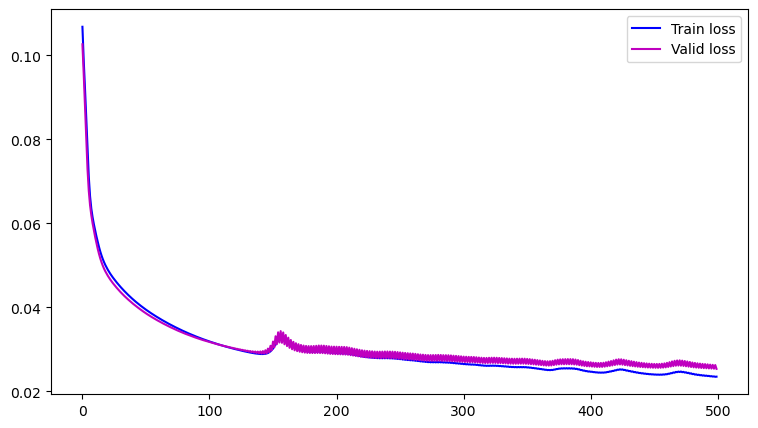

In [13]:
# Training loops
train_losses = []
valid_losses = []

# Run n_epochs of training
for epoch in range(n_epochs):
    train_loss = train_network(network, x_train_, y_train_, learning_rate)
    valid_loss = eval_network(network, x_valid_, y_valid_)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    # For the first, every 5% of the epochs and last epoch, we print the loss 
    # to check that the model is properly training. (loss going down)
    if (n_epochs >= 10 and epoch % math.ceil(0.05 * n_epochs) == 0) or epoch == 0 or epoch == n_epochs:
        print(f"Epoch {epoch}: \n\tTrain Loss:{train_loss:.4f}\tValid Loss:{valid_loss:.4f}")

# Put your own savename to be used for the model and predictions
savename='CustomFilename' 
# saving the model to a file
# Use the .pkl extension to save python pickled files
#save_ffnn_model(f'{savepath}_ffnn_model.pkl', model=network)

# plotting the losses 
plot_losses(train_losses, valid_losses, n_epochs)

# Evaluation on test data

In this part, you will reload a trained model and use it for evaluation.

The binding affinity data has the actual normalized binding affinity value for targets (0,1). In order to compute an AUC, we need to binarize these values into class labels of y=0 or y=1. We use the BINDER_THRESHOLD of 0.426 to do so.

Have a look at how the predictions scores are obtained. The predictions scores are the output of the network after a sigmoid function.

Model loaded successfully from my_NN_ffnn_model.pkl
with weights [ W1, W2 ] dimensions : ((231, 16), (16, 1))


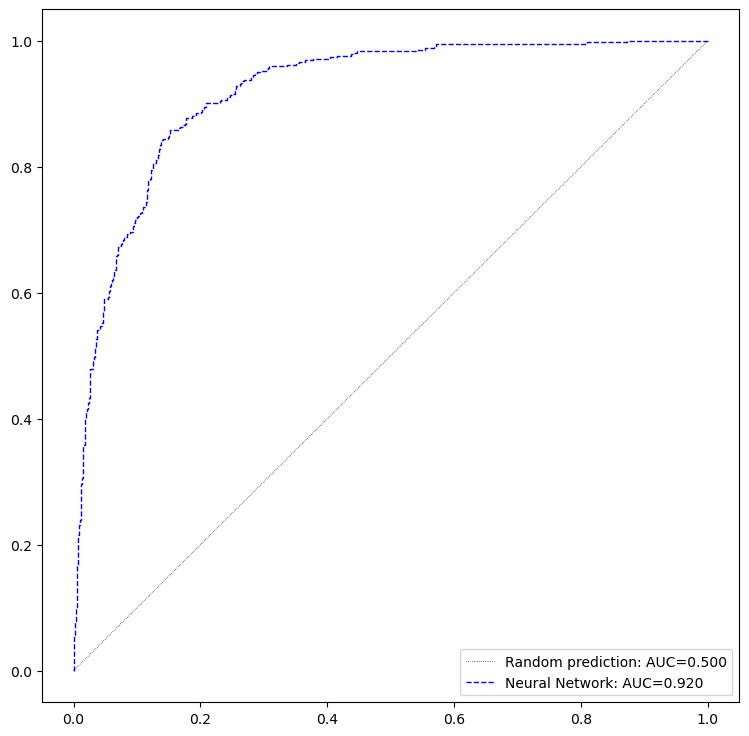

In [14]:
from sklearn.metrics import roc_auc_score, roc_curve
# Reload the model and evaluate it
reloaded_network = load_ffnn_model("my_NN_ffnn_model.pkl", model=network)

BINDER_THRESHOLD=0.426
# Thresholding the targets
y_test_thresholded = (y_test_>=BINDER_THRESHOLD).astype(int)
_, _, _, test_predictions_scores = reloaded_network.forward(x_test_)
test_auc = roc_auc_score(y_test_thresholded.squeeze(), test_predictions_scores.squeeze())
test_fpr, test_tpr, _ = roc_curve(y_test_thresholded.squeeze(), test_predictions_scores.squeeze())

f,a = plt.subplots(1,1 , figsize=(9,9))

a.plot([0,1],[0,1], ls=':', lw=0.5, label='Random prediction: AUC=0.500', c='k')
a.plot(test_fpr, test_tpr, ls='--', lw=1, label=f'Neural Network: AUC={test_auc:.3f}', c='b')
a.legend()

In [15]:
# Saving the predictions
test_raw['predictions'] = test_predictions
test_raw[['peptide','predictions','target']].to_csv(f'{savepath}_ffnn_predictions.txt', index=False, header=False)

NameError: name 'test_predictions' is not defined

# Hyperparameters tuning : Testing multiple model sizes and learning rates and plotting the results:

Training model with hidden size : 10, learning_rate : 0.01
(231, 10) (10,) (10, 1) (1,)


C:\Users\hostp\AppData\Local\Temp\ipykernel_1268\2015594008.py:28: RuntimeWarning: overflow encountered in exp
  return np.where(x >= 0, 1 / (1 + np.exp(-x)),


Training model with hidden size : 20, learning_rate : 0.01
(231, 20) (20,) (20, 1) (1,)
Training model with hidden size : 64, learning_rate : 0.01
(231, 64) (64,) (64, 1) (1,)
Training model with hidden size : 10, learning_rate : 0.0001
(231, 10) (10,) (10, 1) (1,)
Training model with hidden size : 20, learning_rate : 0.0001
(231, 20) (20,) (20, 1) (1,)
Training model with hidden size : 64, learning_rate : 0.0001
(231, 64) (64,) (64, 1) (1,)


C:\Users\hostp\AppData\Local\Temp\ipykernel_1268\1791344647.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


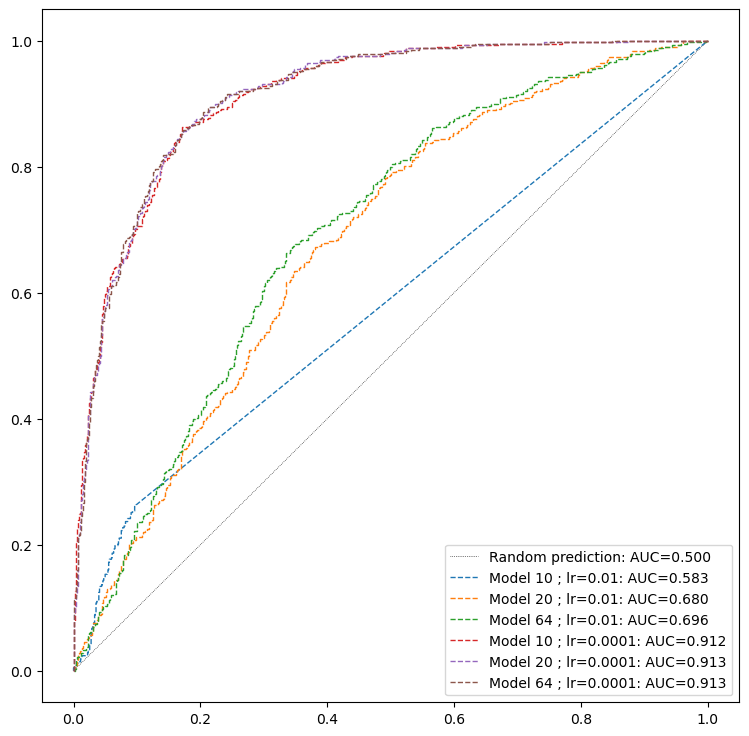

In [16]:
# Training loops
results={}
learning_rate=0.0001
n_epochs = 250


BINDER_THRESHOLD=0.426
# Thresholding the targets
y_test_thresholded = (y_test_>=BINDER_THRESHOLD).astype(int)

f,a = plt.subplots(1,1, figsize=(9,9))
a.plot([0,1],[0,1],ls=':', c='k', lw=0.5, label='Random prediction: AUC=0.500')

# Tuning hyperparameters by looking at which one performs best
for learning_rate in [0.01, 0.0001]:
    for hidden_size in [10, 20, 64]:
        print(f'Training model with hidden size : {hidden_size}, learning_rate : {learning_rate}')
        model = SimpleFFNN(input_size, hidden_size, output_size)
        for _ in range(n_epochs):
            train_network(model, x_train_, y_train_, learning_rate)
        _, _, _, test_predictions_scores = model.forward(x_test_)
        test_auc = roc_auc_score(y_test_thresholded.squeeze(), test_predictions_scores.squeeze())
        test_fpr, test_tpr, _ = roc_curve(y_test_thresholded.squeeze(), test_predictions_scores.squeeze())
        a.plot(test_fpr, test_tpr, ls='--', lw=1, label=f'Model {hidden_size} ; lr={learning_rate}: AUC={test_auc:.3f}')
a.legend()
f.show()

# Argparse part

In [ ]:
# You need to make two scripts train_ffnn.py ; test_ffnn.py: 
#     One for training and saving a model
#     One for loading a saved model and predict

from argparse import ArgumentParser

# Train part
parser = ArgumentParser(description="FFNN train script")
parser.add_argument("-train", action="store", dest="train_data", type=str, help="File with peptides (pep target)")
parser.add_argument("-valid", action="store", dest="valid_data", type=str, help="File with peptides (pep target)")
parser.add_argument("-nh", action="store", dest="n_hidden", type=int, default=16, help="Number of hidden units")
parser.add_argument("-ne", action="store", dest="n_epochs", type=int, default=500, help="Number of epochs")
parser.add_argument("-lr", action="store", dest="learning_rate", type=float, default=0.0001, help="Learning rate")
parser.add_arguemnt("-savepath", action="store", dest="savepath", type=str, default='./CustomName', help='Path to save the result. Used to save the model as {savepath}_ffnn_model.pkl Must not have an extension, ex : ./path/to/my_file')
args = parser.parse_args()
train_data = parser.train_data
valid_data = parser.valid_data
hidden_size = parser.n_hidden
n_epochs = parser.n_epochs
learning_rate = parser.learning_rate
savepath = parser.savepath


In [ ]:

# test part
parser = ArgumentParser(description="FFNN train script")
parser.add_argument("-train", action="store", dest="test_data", type=str, help="File with peptides (pep target)")
parser.add_argument("-nh", action="store", dest="n_hidden", type=int, default=16, help="Number of hidden units")
parser.add_arguemnt("-savepath", action="store", dest="savepath", type=str, default='./CustomName', help='Path to save the result. Used to load the model as {savepath}_ffnn_model.pkl and save the predictions as {savepath}_ffnn_predictions.txt ; Must not have an extension, ex : ./path/to/my_file')
args = parser.parse_args()
test_data = parser.test_data
hidden_size = parser.n_hidden
savepath = parser.savepath